# **Malaria Detection**

## <b>Problem Definition</b>

**The context:**

  Malaria is a life-threatening disease caused by parasites that are transmitted to humans through infected mosquitoes. It remains a significant global health concern, particularly in regions with limited access to healthcare resources. The importance of solving the problem of malaria detection using computer vision lies in its potential to aid in early and accurate diagnosis, which can significantly impact patient outcomes. Timely detection of malaria can facilitate prompt treatment and reduce mortality rates. Furthermore, automated malaria detection can alleviate the burden on healthcare professionals, especially in resource-constrained areas, by providing a rapid and cost-effective screening method.

**The objectives:**

  The goal is to develop a computer vision model based on convolutional neural networks to detect malaria parasites in blood cell images. Specifically, the objectives are:

  - **Accuracy**: To create a model that can accurately identify whether a given blood cell image is infected with malaria or not.

  - **Generalization**: To develop a model that generalizes well to various types of blood cell images, regardless of variations in colors, shapes, luminosity or other factors.

  - **Interpretability**: To provide insights into the features and patterns in the images that the model uses for its predictions, which can aid in understanding the disease and potentially improving the model's performance.

**The key questions:**

  - **What kind of dataset is available?** It's crucial to know the characteristics of the dataset, including the size, quality, and diversity of blood cell images, as well as making sure they are correctly labeled.

  - **What preprocessing steps are needed?** Understanding the preprocessing steps required such as image normalization.

  - **What architecture and hyperparameters should be used for the CNN?** Selecting the appropriate CNN architecture and hyperparameters significantly impact the model's effectiveness.

  - **How will the model be evaluated?**
  Appropriate evaluation metrics for classification must be considered, such as accuracy, precision, recall, and F1-score, as well as a confusion matrix.

**The problem formulation:**

  We aim to develop a computer vision model that can accurately classify blood cell images as either infected with malaria parasites or uninfected. This model will contribute to the early and efficient diagnosis of malaria, which is crucial for timely treatment and improved healthcare outcomes. By leveraging CNN, we seek to build a robust and efficient solution that can be deployed in healthcare settings, particularly in regions with limited access to medical resources, ultimately contributing to the global fight against malaria.

## **Data Description**

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<
**Uninfected:** The uninfected cells are free of the Plasmodium parasites


###<b> Mount the Drive </b>

In [1]:
from pathlib import Path
from google.colab import drive

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Mounted at /content/drive


### **Import the dataset from Kaggle**

In [2]:
DATASET = "iarunava/cell-images-for-detecting-malaria"

In [3]:
! mkdir ~/.kaggle
! cp "{drive_path / 'MyDrive' / 'API' / 'kaggle.json'}" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download "{DATASET}"

100% 675M/675M [00:04<00:00, 172MB/s]
100% 675M/675M [00:04<00:00, 156MB/s]


## **EDA**

In [4]:
# Importing libraries required to load the data
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from zipfile import ZipFile

sns.set()

In [7]:
# Unzip the archive
with content_path / str(DATASET.split("/")[1] + ".zip") as zip_path:
    ZipFile(zip_path, 'r').extractall()

In [8]:
# Root path for the training data
root = content_path / "cell_images"

In [9]:
# Remove nested copy of the directory
! rm -rf cell_images/cell_images

### **Split the data in training and test sets**

In [10]:
# Number of uninfected and parasitized cells in the test dataset
TEST_SET_SIZE = 1300

# Initialize an array for training/test images and labels
x_train, y_train = [], []

# Add uninfected cells to the training and test datasets
uninfected_path = root / "Uninfected"

for filepath in uninfected_path.iterdir():
    if filepath.name.endswith("png"):
        y_train.append(0)
        x_train.append(Image.open(filepath).resize((64, 64)))

# The test set takes the last 1300 images of the uninfected cells
x_test = x_train[-TEST_SET_SIZE:]
y_test = y_train[-TEST_SET_SIZE:]

# Update the training set
x_train = x_train[:-TEST_SET_SIZE]
y_train = y_train[:-TEST_SET_SIZE]

# Add uninfected cells to the training and test datasets
uninfected_path = root / "Parasitized"

for filepath in uninfected_path.iterdir():
    if filepath.name.endswith("png"):
        y_train.append(1)
        x_train.append(Image.open(filepath).resize((64, 64)))

# The test set takes the last 1300 images of the parasitized cells
x_test += x_train[-TEST_SET_SIZE:]
y_test += y_train[-TEST_SET_SIZE:]

# Update the training set
x_train = x_train[:-TEST_SET_SIZE]
y_train = y_train[:-TEST_SET_SIZE]

# Convert the images to arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

<ipython-input-10-ac016e4742d8>:40: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x_train = np.array(x_train)
<ipython-input-10-ac016e4742d8>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(x_train)
<ipython-input-10-ac016e4742d8>:42: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (

### **Normalize the images**

In [11]:
x_train = np.array([np.array(x) / 255 for x in x_train]).astype("float32")
x_test = np.array([np.array(x) / 255 for x in x_test]).astype("float32")

###**Countplots**

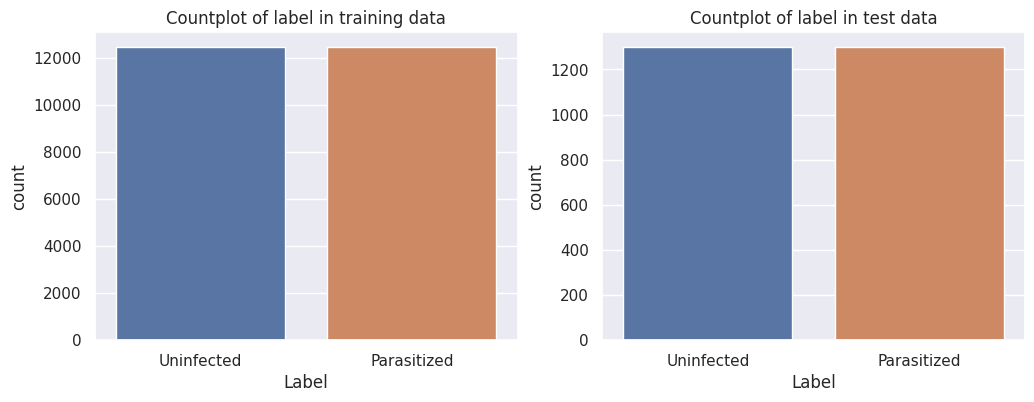

In [12]:
# Create two dataframe to associate each image with its label
df_train = pd.DataFrame(zip(x_train, y_train),
                        columns = ["Image", "Label"])

df_test = pd.DataFrame(zip(x_test, y_test),
                       columns = ["Image", "Label"])

df_train["Label"].replace([0,1],
                          ["Uninfected", "Parasitized"],
                          inplace=True)

df_test["Label"].replace([0,1],
                         ["Uninfected", "Parasitized"],
                         inplace=True)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the countplot of labels in df_train
sns.countplot(
    data = df_train,
    x = "Label",
    ax = axes[0]
)

axes[0].set_title('Countplot of label in training data')

# Plot the countplot of labels in df_test
sns.countplot(
    data = df_test,
    x = "Label",
    ax = axes[1]
)

axes[1].set_title('Countplot of label in test data')

plt.show()

- The training dataset is well balanced with a 50/50 split between the images of parasitized and uninfected cells. Therefore, the models should be able to train on a similar number of images of parasitized and uninfected cells, which is likely to improve the results against new data.

In [13]:
def plot_images(images, labels, n):
    # Set the figure size
    fig = plt.figure(figsize = (n * 2, 2))

    # Generate a list of random indexes
    random_index = [random.randint(0, len(images) + 1) for _ in range(n)]

    # From the random indexes, plot a row of n images with their associated label
    for i in range(n):
        label = "Uninfected" if labels[random_index[i]] == 0 else "Parasitized"
        ax = fig.add_subplot(int("1" + str(n) + str(i)) + 1)
        plt.imshow(images[random_index[i]])
        ax.set_xlabel(label)

    fig.tight_layout()
    plt.show()

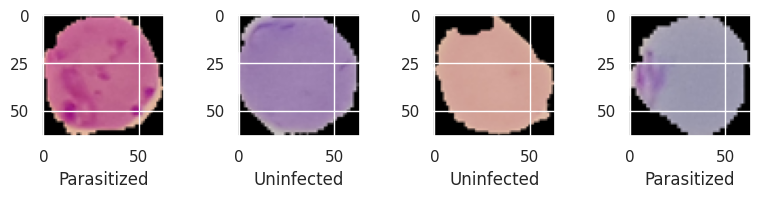

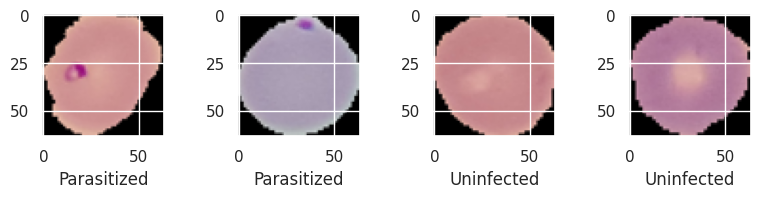

In [14]:
for _ in range(2):
    plot_images(x_train, y_train, 4)

## **CNN**

In [15]:
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)


####<b>One Hot Encoding the train and test labels</b>

In [16]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### **Callbacks**

In [28]:
def checkpoint(fname):

    callbacks = [
        EarlyStopping(patience=10),   # Stop the training after 20 iterations without improvement
        ModelCheckpoint(              # Save the weights giving the best results in a file
            filepath = str(drive_path / "MyDrive" / fname),
            monitor = "val_loss",
            save_best_only = True,
        )
    ]

    return callbacks

#### **Plotting the training and validation loss**

In [18]:
def plot_training(hist):
    # Loss on the training data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['loss'])

    # Loss on the validation data
    plt.plot(range(1, len(hist.epoch) + 1), hist.history['val_loss'])

    # Axis parameters
    plt.ylim(0, 1)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

#### **Evaluating the model on test data**

In [19]:
def prediction(model, x_test, y_test):
    # Apply the model to the test dataset to get new predictions
    y_pred = model.predict(x_test)
    # Get the index of the 1 in the predicted labels and true labels
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = np.argmax(y_test_encoded, axis=1)

    return y_test_arg, y_pred_arg

#### **Plotting the confusion matrix**

In [20]:
def report_and_matrix(test, pred):
    # Print the classification report
    report = classification_report(test, pred)

    print(report)
    print("----------------------------------------------------------------------")
    print()

    # Plot the confusion matrix
    cm = tf.math.confusion_matrix(test, pred)
    ax = sns.heatmap(
            cm,
            annot = True,
            linewidths = 0.4,
            fmt = "d",
            square = True,
         )

    ax.set(
        xlabel = 'Predicted Labels',
        ylabel = 'True Labels',
    )

    plt.show()

    # Return the report and the confusion matrix in a dictionary
    return {"report": report, "matrix": cm}

In [21]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

#### **Building the model**

In [22]:
def model_1():
    # Sequential model
    model = Sequential()

    # First convolution layer with 32 filters
    model.add(
        Conv2D(
            filters = 32,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
            input_shape = (64, 64, 3),
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # Second convolution layer with 64 filters
    model.add(
        Conv2D(
            filters = 64,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # Third convolution layer with 128 filters
    model.add(
        Conv2D(
            filters = 128,
            kernel_size = 2,
            padding="same",
            activation="relu",
        )
    )

    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(rate = 0.3))

    # FFNN
    model.add(Flatten())
    model.add(
        Dense(
            128,
            activation = 'relu',
        )
    )

    model.add(Dropout(rate=0.5))
    model.add(
        Dense(
            2,
            activation = 'softmax',
        )
    )

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer = Adam(learning_rate = 0.0005),
        metrics = ["accuracy"]
    )

    return model

In [23]:
m_1 = model_1()

m_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

**Fit and Train the model**

In [29]:
history_1 = m_1.fit(
                x_train,
                y_train_encoded,
                epochs=100,
                callbacks=checkpoint("weights_model_1.hdf5"),
                validation_split=0.2,
                batch_size=32,
                verbose=1
            )

Epoch 1/100
624/624 [==============================] - 4s 7ms/step - loss: 0.1490 - accuracy: 0.9555 - val_loss: 0.1463 - val_accuracy: 0.9465
Epoch 2/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1450 - accuracy: 0.9579 - val_loss: 0.1981 - val_accuracy: 0.9201
Epoch 3/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1352 - accuracy: 0.9585 - val_loss: 0.1804 - val_accuracy: 0.9371
Epoch 4/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1320 - accuracy: 0.9590 - val_loss: 0.1527 - val_accuracy: 0.9417
Epoch 5/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1277 - accuracy: 0.9602 - val_loss: 0.1676 - val_accuracy: 0.9411
Epoch 6/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1229 - accuracy: 0.9606 - val_loss: 0.1663 - val_accuracy: 0.9421
Epoch 7/100
624/624 [==============================] - 3s 5ms/step - loss: 0.1229 - accuracy: 0.9606 - val_loss: 0.2075 - val_accuracy: 0.9271

**Plotting the train and the validation curves**

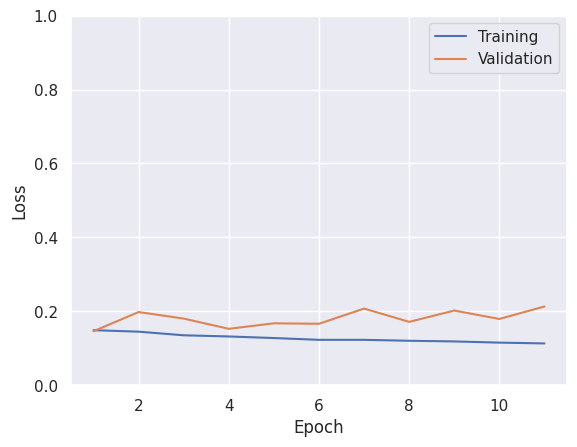

In [30]:
plot_training(history_1)

The model overfits the training data, as the loss does not decrease on the validation set.

#### **Evaluating the model**

In [31]:
test_1, pred_1 = prediction(m_1, x_test, y_test_encoded)

82/82 [==============================] - 0s 3ms/step


#### **Plotting the confusion matrix**

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.93      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



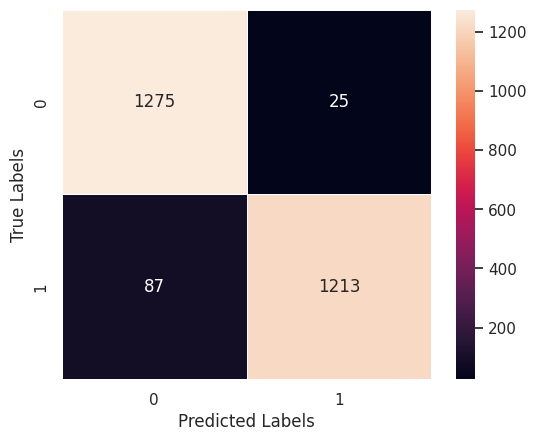

In [32]:
stat_1 = report_and_matrix(test_1, pred_1)

- Label 0 = uninfected, label 1 = parasitized
- This model reaches a 96% accuracy on the test data. It misclassified 112 cells, including 87 false negatives. It is critical to minimize this number which represents the parasitized cells predicted as uninfected, in the case of a diagnosis.

## **Data Augmentation**

In [33]:
from sklearn.model_selection import train_test_split

# Split the training data into training images/labels and validation images/labels with a ratio of 80%/20%
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train,
                                                                  y_train_encoded,
                                                                  test_size=0.2,
                                                                  random_state=42)

# Parameters to generate new images
generator = ImageDataGenerator(
                horizontal_flip=True, # Can flip the image upside down
                zoom_range=0.5,       # Can zoom in the image up to 2x
                rotation_range=30     # Can rotate the image up to 30°
            )

# Create an iterator with new images
augmented_data = generator.flow(
                    x=x_train_aug,
                    y=y_train_aug,
                    batch_size=32,
                    seed=42,
                    shuffle=True
                 )

In [34]:
m_2 = model_1()

In [36]:
history_2 = m_2.fit(
                augmented_data,
                epochs=100,
                callbacks=checkpoint("MyDrive/weights_model_5.hdf5"),
                validation_data=(x_val_aug, y_val_aug),
                verbose=1
            )

Epoch 1/100
624/624 [==============================] - 24s 36ms/step - loss: 0.6506 - accuracy: 0.6251 - val_loss: 0.5896 - val_accuracy: 0.7554
Epoch 2/100
  3/624 [..............................] - ETA: 20s - loss: 0.6237 - accuracy: 0.6562

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


624/624 [==============================] - 22s 35ms/step - loss: 0.3834 - accuracy: 0.8522 - val_loss: 0.2088 - val_accuracy: 0.9181
Epoch 3/100
624/624 [==============================] - 22s 35ms/step - loss: 0.2770 - accuracy: 0.8991 - val_loss: 0.1833 - val_accuracy: 0.9323
Epoch 4/100
624/624 [==============================] - 21s 34ms/step - loss: 0.2672 - accuracy: 0.9077 - val_loss: 0.1844 - val_accuracy: 0.9349
Epoch 5/100
624/624 [==============================] - 21s 34ms/step - loss: 0.2583 - accuracy: 0.9110 - val_loss: 0.1701 - val_accuracy: 0.9481
Epoch 6/100
624/624 [==============================] - 22s 35ms/step - loss: 0.2518 - accuracy: 0.9146 - val_loss: 0.1658 - val_accuracy: 0.9455
Epoch 7/100
624/624 [==============================] - 21s 34ms/step - loss: 0.2437 - accuracy: 0.9166 - val_loss: 0.1650 - val_accuracy: 0.9535
Epoch 8/100
624/624 [==============================] - 21s 34ms/step - loss: 0.2383 - accuracy: 0.9190 - val_loss: 0.1602 - val_accuracy: 0.95

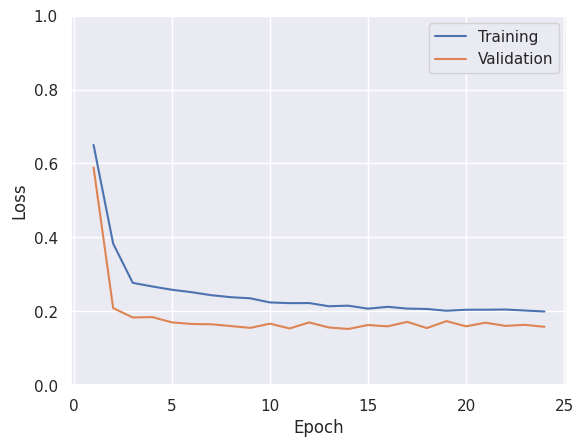

In [37]:
plot_training(history_2)

In [38]:
test_2, pred_2 = prediction(m_2, x_test, y_test_encoded)

82/82 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600

----------------------------------------------------------------------



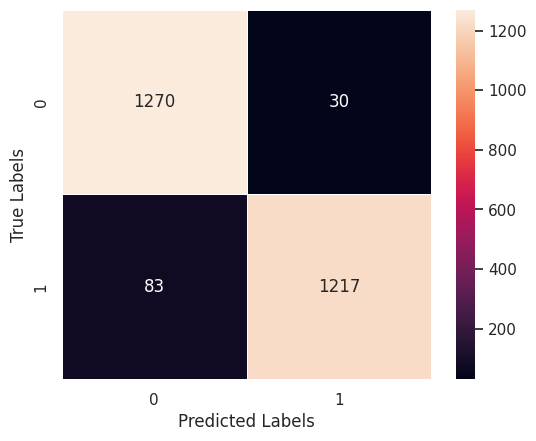

In [39]:
stat_5 = report_and_matrix(test_2, pred_2)

- The accuracy is again rounded to 96%, but with only 103 misclassification this time, including 83 false negatives.
- Data augmentation provides a tool to make the training more robust with more general features via the distorsion of the images, hence reducing overfitting, as seen in the loss plot.
- The validation loss remains inferior to the training loss at all epoch. Therefore, the model trained on augmented data is more accurate while avoiding overfitting.